In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5
f(20)

1125

In [3]:
xs = np.arange(-5,5,0.2)
ys= f(xs)
ys

array([100.  ,  93.32,  86.88,  80.68,  74.72,  69.  ,  63.52,  58.28,
        53.28,  48.52,  44.  ,  39.72,  35.68,  31.88,  28.32,  25.  ,
        21.92,  19.08,  16.48,  14.12,  12.  ,  10.12,   8.48,   7.08,
         5.92,   5.  ,   4.32,   3.88,   3.68,   3.72,   4.  ,   4.52,
         5.28,   6.28,   7.52,   9.  ,  10.72,  12.68,  14.88,  17.32,
        20.  ,  22.92,  26.08,  29.48,  33.12,  37.  ,  41.12,  45.48,
        50.08,  54.92])

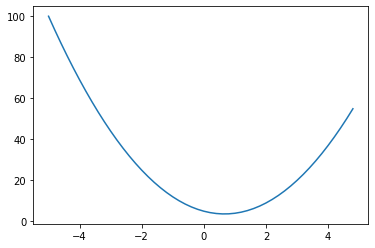

In [4]:
plt.plot(xs,ys)

In [5]:
h=0.00000001
x=3.0
(f(x+h)-f(x))/h

14.00000009255109

In [6]:
a=2.0
b=-3.0
c=10.0
d=a*b+c
print(d)

4.0


In [7]:
h=0.0001
a=2.0
b=-3.0
c=10.0

d1=a*b+c
c+=h
d2=a*b+c

print("d1",d1)
print("d2",d2)
print("slope",(d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [8]:
class Value:
  
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
  
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():      
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
  
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
  
    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
        out._backward = _backward

        return out
  
  
    def backward(self):
    
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [9]:
a=Value(2.0,label='a')
b=Value(-3.0,label='b')
c=Value(10.0,label='c')
e=a*b
e.label = "e"
d=e+c
d.label ="d"
f=Value(-2.0,label ="f")
L=d*f
L

Value(data=-8.0)

In [10]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [11]:
a=Value(2.0)
b=Value(4.0)
a/b

Value(data=0.5)

In [12]:
L.grad=1.0

In [13]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [14]:
o.backward()

In [15]:
print(o.grad)
print(n.grad)
print(x1w1x2w2.grad)
print(x1w1.grad)
print(x2w2.grad)
print(x1.grad)
print(x2.grad)
print(w1.grad)
print(w2.grad)

1.0
0.4999999999999999
0.4999999999999999
0.4999999999999999
0.4999999999999999
-1.4999999999999996
0.4999999999999999
0.9999999999999998
0.0


In [16]:
import torch

In [17]:
x1 = torch.Tensor([2.0]).double()                
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data)
print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

tensor([0.7071], dtype=torch.float64)
0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [18]:
import random

In [19]:
class Neuron: 
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
  
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
  
    def parameters(self):
        return self.w + [self.b]

class Layer:
  
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
  
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
  
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
  
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [20]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.6249681769853814)

In [21]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [22]:
for k in range(20):
  
  # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
  
  # update
    for p in n.parameters():
        p.data += -0.1 * p.grad
  
    print(k, loss.data)

0 5.896673711003655
1 2.4801732648459573
2 3.4967547433556345
3 1.3681027041360665
4 0.08756215543268603
5 0.0677586616158238
6 0.05736448551412973
7 0.050341758746824325
8 0.045062061633639766
9 0.040862940791491234
10 0.037407658745179456
11 0.034498769225829416
12 0.032008831509382586
13 0.029849948238584428
14 0.027958566896184846
15 0.02628711459307733
16 0.024799026233138847
17 0.023465605918811222
18 0.022263949196037892
19 0.021175514559469324


In [23]:
ypred

[Value(data=0.9128151487876629),
 Value(data=-0.9399751574440236),
 Value(data=-0.9154516548934555),
 Value(data=0.9468689178123872)]